<a href="https://colab.research.google.com/github/aminsarzaeem/deep/blob/main/hw4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A

in this section we will evaluate data the form of data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import pad_sequences



In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/deep'
data = pd.read_csv(path+'/BBBP.csv')
data.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [4]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 38.0 MB/s eta 0:00:00


In [12]:
from rdkit import Chem
smiles=data['smiles']
mol = Chem.MolFromSmiles(smiles[0]) # Convert SMILES string to RDKit molecule
# Convert molecule to numerical sequence
sequence = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
np.array(sequence)

array([17,  6,  6,  6,  7,  6,  6,  8,  6,  8,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6])

this function just consider the atoms in the mol and do not consider the bonds.
so we write the tokenization code.

In [6]:
data['smiles'][0]

'[Cl].CC(C)NCC(O)COc1cccc2ccccc12'

In [ ]:
smiles=data['smiles']
string_smiles = '|'.join(smiles) # all data as string
type(string_smiles)
set(string_smiles)

**separating different characters**

In [5]:
import re
split = re.findall('Br|Na|Ca|Cl|@@|\d+|\D', string_smiles)
tokens=set(split)
print(set(split))

{'P', '89', '127', '@', 'O', '25', '126', '%', 'c', 'F', '8', '34', '69', 'Br', 'Ca', 'Cl', '125', '15', '3', '(', '123', '.', 'B', '4', 'N', 'o', '23', '135', '56', '5', ')', '32', '2', '14', ']', '10', '21', '27', '234', '11', '@@', '+', '9', '13', 'C', '35', '#', 'S', 'n', 'Na', '37', '134', '/', '|', 's', '12', '=', 'I', '45', '26', '-', '67', '7', '[', '6', '36', '235', '24', '\\', '1', 'H'}


In [74]:
np.where([np.array(['|']+split+['|']) == '|'])[1]

(2051,)

now we will plot the histogram of sequences length as we see the sequence length is around 50 characters. however th maximum length is much more about 400. this variation makes the training process difficult.

In [6]:
mol_len=np.diff(np.where([np.array(['|']+list(string_smiles)+['|']) == '|'])[1])-1

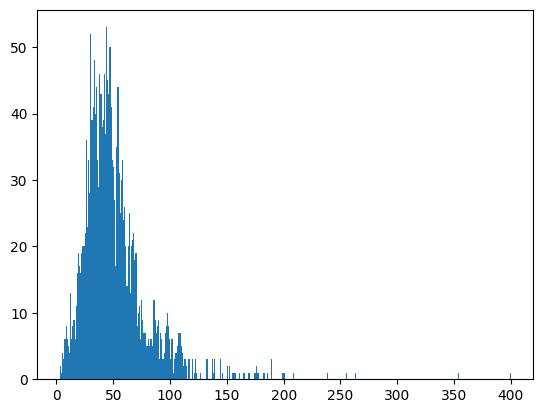

In [60]:
import matplotlib.pyplot as plt
plt.hist(mol_len,max(mol_len))
plt.show()

now we plot the frequency of each character. we observe that many of characters apear a few times but in one hot encoder we consider all.

In [7]:
tokfreq={}
for token in tokens:
  token_pr = token
  tokfreq[token_pr] = np.sum(np.array(split) == token)

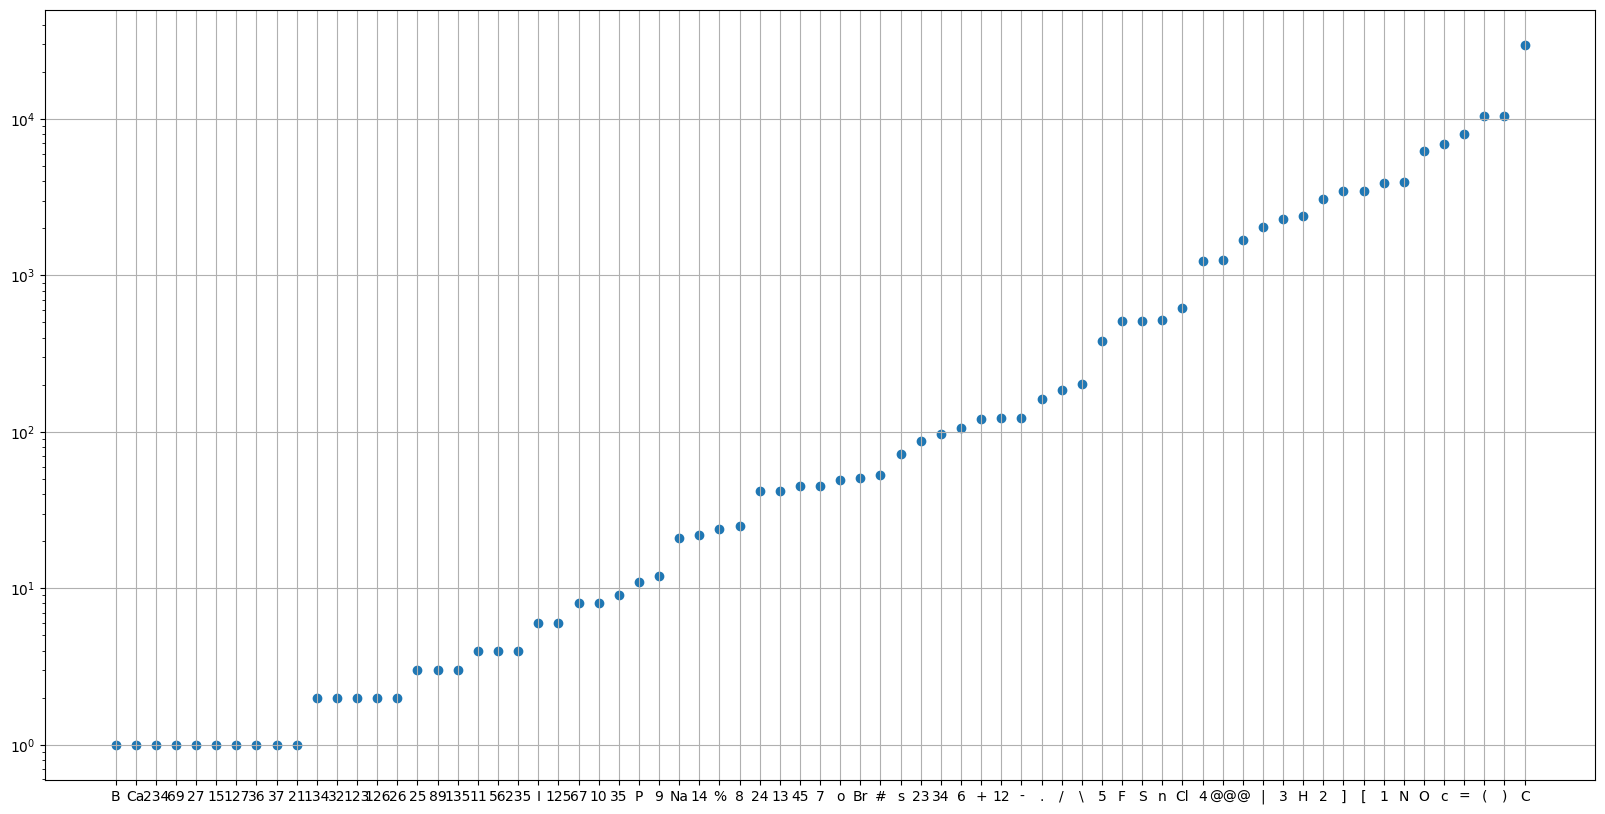

In [61]:
idx = np.argsort(list(tokfreq.values()), )
plt.figure(figsize = (20,10))
plt.scatter(np.array(list(tokfreq.keys()))[idx], np.array(list(tokfreq.values()))[idx])
plt.yscale('log')
plt.grid()

In [7]:
maxlen=max(mol_len)
maxlen

400

In [8]:
spliteddata=[]
templist=[]
for i in split+['|']:
  if i=='|':
    spliteddata.append(templist+(maxlen - len(templist))* ['pad'])
    templist=[]
  else:
    templist.append(i)

In [82]:
len(spliteddata)

2050

# B

one hot encoder: in this part we define the molculs in a sequence of length 400 and each character has a one hot encoder of length 71. also the padded sequence is zero vector.

In [9]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop= ['pad']*maxlen, sparse_output= False)
encoder.fit(np.array([list(tokens)+['pad']]*maxlen).T)
onehot = encoder.transform(np.array(spliteddata))

In [10]:
#10 bin for last part
spliteddata2={}
label={}
onehot2={}
for i in range(10):
  spliteddata2[i]=[]
  label[i]=[]
templist=[]
j=0
for i in split+['|']:
  if i=='|':
    spliteddata2[(len(templist)-1)//40].append(templist+(maxlen - len(templist))* ['pad'])
    label[(len(templist)-1)//40].append(data['p_np'][j])
    j+=1
    templist=[]
  else:
    templist.append(i)
for i in range(10):
  #print(type(spliteddata2[i]))
  maxlen2=(i+1)*40
  encoder = OneHotEncoder(drop= ['pad']*maxlen, sparse_output= False)
  encoder.fit(np.array([list(tokens)+['pad']]*maxlen).T)
  if(len(spliteddata2[i])>0):
    onehot2[i] = encoder.transform(np.array(spliteddata2[i]))
  else:
    print(i,spliteddata2[i])

7 []


**fully connected**

now we consider the 71*400 vectors as input of a neural network

In [11]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler

In [14]:
class bbbp_dataset(Dataset):
    def __init__(self, data, labels, shuffle = True):
        self.num_data = len(labels)
        if(shuffle):
          idxs = np.random.choice(self.num_data, self.num_data, replace = False)
          self.data = data[idxs]
          self.targets = list(np.array(labels)[idxs])
        else:
          self.data = data.clone()
          self.targets = labels.copy()

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def __len__(self):
        return self.num_data

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(onehot, data['p_np'], test_size=0.2, random_state=42)
traindataset = bbbp_dataset(torch.from_numpy(X_train), list(y_train))
trainloader = DataLoader(traindataset, batch_size=32)
testdataset = bbbp_dataset(torch.from_numpy(X_test), list(y_test))
testloader = DataLoader(testdataset, batch_size=32)


In [22]:
class FC_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        o1=self.fc1(x)
        o2=F.relu(o1)
        out = self.fc2(o2)
        return out

def train_model(model, train_loader, test_loader, num_epochs, device='cuda',dtype=torch.float32,lr = 1e-3):
  model = model.to(device)
  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  # Training loop
  total_step = len(train_loader)
  for epoch in range(num_epochs):
    model.train()
    for i, (X, y) in enumerate(train_loader):
        # Move images and labels to the device
        X = X.to(device,dtype)
        y = y.to(device)

        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print training loss every epochs
    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")
    model.eval()
    l=0
    correct=0
    total=0
    with torch.no_grad():
      for X, y in test_loader:
        X = X.to(device,dtype)
        y = y.to(device)

        # Forward pass
        outputs = model(X)
        l+=criterion(outputs, y).item()
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
      accuracy = 100 * correct / total
      print(f"Test Accuracy: {accuracy:.2f} %")
  return accuracy, model

In [37]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print('device = ', device)
dtype = torch.float
model = FC_model(28400, 400, 2)
train_model(model, trainloader, testloader, num_epochs = 10, device=device, lr = 1e-3)

device =  cpu
Epoch [1/10], Step [52/52], Loss: 0.2091
Test Accuracy: 85.85 %
Epoch [2/10], Step [52/52], Loss: 0.0778
Test Accuracy: 85.85 %
Epoch [3/10], Step [52/52], Loss: 0.0404
Test Accuracy: 86.10 %
Epoch [4/10], Step [52/52], Loss: 0.0210
Test Accuracy: 86.34 %
Epoch [5/10], Step [52/52], Loss: 0.0113
Test Accuracy: 87.32 %
Epoch [6/10], Step [52/52], Loss: 0.0056
Test Accuracy: 86.59 %
Epoch [7/10], Step [52/52], Loss: 0.0029
Test Accuracy: 85.85 %
Epoch [8/10], Step [52/52], Loss: 0.0019
Test Accuracy: 86.10 %
Epoch [9/10], Step [52/52], Loss: 0.0012
Test Accuracy: 86.10 %
Epoch [10/10], Step [52/52], Loss: 0.0009
Test Accuracy: 85.61 %


(85.60975609756098,
 FC_model(
   (fc1): Linear(in_features=28400, out_features=400, bias=True)
   (fc2): Linear(in_features=400, out_features=2, bias=True)
 ))

we conclude that the accuracy of this model is about 85  percent which is acceptable for this simple model.

In [57]:
#different bin accuracy
model.eval()
for i in range(10):
  if(len(label[i])>0):

    l=0
    correct=0
    total=0
    with torch.no_grad():
      for (X, y) in zip(onehot2[i],label[i]):
        X = torch.from_numpy(X).to(device,dtype)

  # Forward pass
        outputs = model(X)
    #l+=nn.CrossEntropyLoss(outputs, y).item()
        _, predicted = torch.max(outputs.data,0)
        total += 1
        correct += (predicted == y).sum().item()

      accuracy = 100 * correct / total
      print(f"Test Accuracy bin {i}: {accuracy:.2f} %")

Test Accuracy bin 0: 96.76 %
Test Accuracy bin 1: 97.56 %
Test Accuracy bin 2: 96.15 %
Test Accuracy bin 3: 100.00 %
Test Accuracy bin 4: 94.44 %
Test Accuracy bin 5: 100.00 %
Test Accuracy bin 6: 100.00 %
Test Accuracy bin 8: 100.00 %
Test Accuracy bin 9: 100.00 %


# C

in this section we define an lstm model concatinated with a fully connected network for label prediction.

In [12]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, device='cuda',dtype=torch.float32, bidirectional = False):
        super().__init__()
        self.hidden_size = hidden_size
        self.Bidirectional = bidirectional
        self.LSTM = nn.LSTM(input_size, hidden_size, batch_first= True, bidirectional= bidirectional)
        if bidirectional:
          self.fc = nn.Linear(hidden_size*2, num_classes)
        else:
          self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, device = 'cuda'):
        if(self.Bidirectional):
          h_0 = torch.zeros((2, len(x), self.hidden_size), device = device)
          c_0 = torch.zeros((2, len(x), self.hidden_size), device = device)
        else:
          h_0 = torch.zeros((1, len(x), self.hidden_size), device = device)
          c_0 = torch.zeros((1, len(x), self.hidden_size), device = device)
        out, (hn, cn) = self.LSTM(x, (h_0, c_0))
        if(self.Bidirectional):
          output = self.fc(torch.cat((hn[0], hn[1]), dim=1))
        else:
          output = self.fc(hn[0])
        return output

def train_lstm(model, train_loader, test_loader,num_epochs,device='cuda', dtype=torch.float32, lr = 1e-3):
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  total_step = len(train_loader)
  for epoch in range(num_epochs):
    model.train()
    for i, (X, y) in enumerate(train_loader):
        # Move images and labels to the device
        X = X.to(device,dtype)
        y = y.to(device)

        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Print training loss every epochs
    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")
    model.eval()
    l=0
    correct=0
    total=0
    with torch.no_grad():
      for X, y in test_loader:
        X = X.to(device,dtype)
        y = y.to(device)

        # Forward pass
        outputs = model(X)
        l+=criterion(outputs, y).item()
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
      accuracy = 100 * correct / total
      print(f"Test Accuracy: {accuracy:.2f} %")
  return accuracy, model

In [15]:
X_train, X_test, y_train, y_test = train_test_split(np.flip(onehot.reshape((len(onehot),maxlen,-1)),1), data['p_np'], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(onehot.reshape((len(onehot),maxlen,-1)), data['p_np'], test_size=0.2, random_state=42)
traindataset = bbbp_dataset(torch.from_numpy(X_train), list(y_train))
trainloader = DataLoader(traindataset, batch_size=32)
testdataset = bbbp_dataset(torch.from_numpy(X_test), list(y_test))
testloader = DataLoader(testdataset, batch_size=32)

In [16]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print('device = ', device)
lstm_model = LSTM_model(71, 400, 2)
train_lstm(lstm_model, trainloader, testloader, num_epochs = 10,device=device,lr=1e-3)

device =  cuda
Epoch [1/10], Step [52/52], Loss: 0.6543
Test Accuracy: 76.83 %
Epoch [2/10], Step [52/52], Loss: 0.5106
Test Accuracy: 78.78 %
Epoch [3/10], Step [52/52], Loss: 0.4011
Test Accuracy: 80.98 %
Epoch [4/10], Step [52/52], Loss: 0.3726
Test Accuracy: 82.20 %
Epoch [5/10], Step [52/52], Loss: 0.2817
Test Accuracy: 81.95 %
Epoch [6/10], Step [52/52], Loss: 0.3585
Test Accuracy: 79.76 %
Epoch [7/10], Step [52/52], Loss: 0.2542
Test Accuracy: 82.44 %
Epoch [8/10], Step [52/52], Loss: 0.2887
Test Accuracy: 82.68 %
Epoch [9/10], Step [52/52], Loss: 0.2619
Test Accuracy: 80.98 %
Epoch [10/10], Step [52/52], Loss: 0.2850
Test Accuracy: 84.63 %


(84.63414634146342,
 LSTM_model(
   (LSTM): LSTM(71, 400, batch_first=True)
   (fc): Linear(in_features=400, out_features=2, bias=True)
 ))

we conclude the with 10 epoch training the accuracy is 84 which is about fc network accuracy. the key point is that we should set the parameter to avoid saddle points.this is abit hard.

In [17]:
#different bin accuracy
lstm_model.eval()
for i in range(10):
  correct=0
  if(len(label[i])>0):
    xtemp=np.flip(onehot2[i].reshape((len(onehot2[i]),maxlen,-1)),1).copy()
    outputs=lstm_model(torch.from_numpy(xtemp).to(device,torch.float32))
    _, predicted = torch.max(outputs.data,1)
    correct = (predicted == torch.tensor(label[i]).to(device)).sum().item()

    accuracy = 100 * correct / len(label[i])
    print(f"Accuracy bin {i}: {accuracy:.2f} %")

Accuracy bin 0: 85.23 %
Accuracy bin 1: 85.08 %
Accuracy bin 2: 87.91 %
Accuracy bin 3: 70.37 %
Accuracy bin 4: 88.89 %
Accuracy bin 5: 0.00 %
Accuracy bin 6: 50.00 %
Accuracy bin 8: 0.00 %
Accuracy bin 9: 100.00 %


# D

now we add bidirectional lstm to the last code and observe the results.

In [18]:
lstm_model = LSTM_model(71, 400, 2, bidirectional=True)
train_lstm(lstm_model, trainloader, testloader, num_epochs = 10,device=device,lr=1e-3)

Epoch [1/10], Step [52/52], Loss: 0.6299
Test Accuracy: 76.83 %
Epoch [2/10], Step [52/52], Loss: 0.5353
Test Accuracy: 78.05 %
Epoch [3/10], Step [52/52], Loss: 0.4361
Test Accuracy: 79.02 %
Epoch [4/10], Step [52/52], Loss: 0.3385
Test Accuracy: 81.46 %
Epoch [5/10], Step [52/52], Loss: 0.3295
Test Accuracy: 82.68 %
Epoch [6/10], Step [52/52], Loss: 0.2573
Test Accuracy: 85.61 %
Epoch [7/10], Step [52/52], Loss: 0.2694
Test Accuracy: 84.88 %
Epoch [8/10], Step [52/52], Loss: 0.2131
Test Accuracy: 85.37 %
Epoch [9/10], Step [52/52], Loss: 0.2240
Test Accuracy: 87.07 %
Epoch [10/10], Step [52/52], Loss: 0.3321
Test Accuracy: 83.17 %


(83.17073170731707,
 LSTM_model(
   (LSTM): LSTM(71, 400, batch_first=True, bidirectional=True)
   (fc): Linear(in_features=800, out_features=2, bias=True)
 ))

we conclude that the bidiractional lstm for this problem has a bit more accuracy than simple lstm. this may be as result of considering future of sequence in current states. however this increase is not very sensible.

In [19]:
#different bin accuracy
lstm_model.eval()
for i in range(10):
  correct=0
  if(len(label[i])>0):
    xtemp=np.flip(onehot2[i].reshape((len(onehot2[i]),maxlen,-1)),1).copy()
    outputs=lstm_model(torch.from_numpy(xtemp).to(device,torch.float32))
    _, predicted = torch.max(outputs.data,1)
    correct = (predicted == torch.tensor(label[i]).to(device)).sum().item()

    accuracy = 100 * correct / len(label[i])
    print(f"Accuracy bin {i}: {accuracy:.2f} %")

Accuracy bin 0: 83.91 %
Accuracy bin 1: 83.65 %
Accuracy bin 2: 86.26 %
Accuracy bin 3: 74.07 %
Accuracy bin 4: 88.89 %
Accuracy bin 5: 0.00 %
Accuracy bin 6: 50.00 %
Accuracy bin 8: 0.00 %
Accuracy bin 9: 100.00 %


# E Kfold


In [20]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print('device = ', device)
from sklearn.model_selection import KFold
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

xtemp=np.flip(onehot.reshape((len(onehot),maxlen,-1)),1).copy()
dataset=bbbp_dataset(torch.from_numpy(xtemp), list(data['p_np']))
# K-fold Cross Validation model evaluation
results={}
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(dataset,
                      batch_size=10, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(dataset,
                      batch_size=10, sampler=test_subsampler)

    # Init the neural network
    model = LSTM_model(71, 400, 2, bidirectional=False)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    total_step = len(trainloader)
    for epoch in range(10):
      model.train()
      totalloss=0
      for i, (X, y) in enumerate(trainloader):
        # Move images and labels to the device
        X = X.to(device,torch.float32)
        y = y.to(device)

        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        totalloss+=loss.item()
      # Print training loss every epochs
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0
      #print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {totalloss:.4f}")

    # Process is complete.
    #print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')

    # Saving the model
    #save_path = f'./model-fold-{fold}.pth'
    #torch.save(network.state_dict(), save_path)
    model.eval()
    l=0
    correct=0
    total=0
    with torch.no_grad():
      for X, y in testloader:
        X = X.to(device,torch.float32)
        y = y.to(device)

        # Forward pass
        outputs = model(X)
        l+=criterion(outputs, y).item()
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
      accuracy = 100 * correct / total
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      results[fold] = 100.0 * (correct / total)

# Print fold results
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

device =  cuda
Starting testing
Accuracy for fold 0: 88 %
Starting testing
Accuracy for fold 1: 81 %
Starting testing
Accuracy for fold 2: 73 %
Starting testing
Accuracy for fold 3: 84 %
Starting testing
Accuracy for fold 4: 83 %
Fold 0: 88.29268292682927 %
Fold 1: 81.70731707317073 %
Fold 2: 73.90243902439025 %
Fold 3: 84.14634146341463 %
Fold 4: 83.90243902439025 %
Average: 82.39024390243904 %


In [23]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print('device = ', device)
from sklearn.model_selection import KFold
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

xtemp=onehot.copy()
dataset=bbbp_dataset(torch.from_numpy(xtemp), list(data['p_np']))
# K-fold Cross Validation model evaluation
results={}
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(dataset,
                      batch_size=10, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(dataset,
                      batch_size=10, sampler=test_subsampler)

    # Init the neural network
    model = FC_model(28400, 400, 2)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    total_step = len(trainloader)
    for epoch in range(10):
      model.train()
      totalloss=0
      for i, (X, y) in enumerate(trainloader):
        # Move images and labels to the device
        X = X.to(device,torch.float32)
        y = y.to(device)

        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        totalloss+=loss.item()
      # Print training loss every epochs
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0
      #print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {totalloss:.4f}")

    # Process is complete.
    #print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')

    # Saving the model
    #save_path = f'./model-fold-{fold}.pth'
    #torch.save(network.state_dict(), save_path)
    model.eval()
    l=0
    correct=0
    total=0
    with torch.no_grad():
      for X, y in testloader:
        X = X.to(device,torch.float32)
        y = y.to(device)

        # Forward pass
        outputs = model(X)
        l+=criterion(outputs, y).item()
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
      accuracy = 100 * correct / total
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      results[fold] = 100.0 * (correct / total)

# Print fold results
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

device =  cuda
Starting testing
Accuracy for fold 0: 84 %
Starting testing
Accuracy for fold 1: 85 %
Starting testing
Accuracy for fold 2: 88 %
Starting testing
Accuracy for fold 3: 87 %
Starting testing
Accuracy for fold 4: 88 %
Fold 0: 84.6341463414634 %
Fold 1: 85.60975609756098 %
Fold 2: 88.78048780487805 %
Fold 3: 87.3170731707317 %
Fold 4: 88.78048780487805 %
Average: 87.02439024390245 %


the cross validation of simple lstm is about 82 and cross val of fc network is about 87 percent.

# F
the main reson of bidirectional lstm better perfomance is that the future of sequence effect on previous states. thus it is more capable to model character dependence in a sequence.

# G

we implement the part after each part with the title of 10 bin accuracy. observing these results, it seems that by increasing sequence length the accuracy is increasing. this may be as result of less paddings in long sequences.( take care that long sequences are less frequent thus their accuracy are less reliable.)